In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA

%matplotlib inline

In [212]:
data = pd.read_excel('C:/Users/raflg/Downloads/Databases/Générateur GPS.xlsx', sheet_name='Data')
df = data.copy()

i = 1
for a in df.Athlete.unique():
    df.loc[df['Athlete']==a, 'Athlete'] = 'Player ' + str(i)
    i +=1

df

,Athlete,Unit,Group,Position,Date,Week,Type,Game day,Kind,Distance Total (m),m/min,High Int Speed (m),Sprints (m),Hi Int Acceleration (nb),Hi Int Deceleration (nb),80% Distance Hi Int (m),85% Distance Hi Int (m),90% Distance Hi Int (m),>85% Distance (m)
0,Player 1,Forward,Tight Forwards,Lock,2016-12-02,Week 1,Training,NaN,NaN,9386,79,1312,115,146,50,7,4,14,18
1,Player 2,Back,Midfield,2nd Five / Inside Centre,2016-12-02,Week 1,Training,NaN,NaN,6712,57,1184,83,71,46,0,0,0,0
2,Player 3,Back,Outside Backs,Wing,2016-12-02,Week 1,Training,NaN,NaN,9621,81,1429,110,145,57,23,2,0,2
3,Player 4,Forward,Tight Forwards,Lock,2016-12-02,Week 1,Training,NaN,NaN,8779,74,702,76,60,22,0,0,0,0
4,Player 5,Forward,Loose Forwards,Flanker,2016-12-02,Week 1,Training,NaN,NaN,798,74,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,Player 37,Back,Outside Backs,Wing,2017-07-29,Week 35,Game,SF,Away,1652,18,271,36,11,13,8,0,0,0
3840,Player 13,Forward,Loose Forwards,Flanker,2017-07-29,Week 35,Game,SF,Away,4627,52,368,101,21,17,0,0,0,0
3841,Player 14,Back,Inside Backs,Halfback,2017-07-29,Week 35,Game,SF,Away,1672,18,176,33,9,7,3,2,0,2
3842,Player 16,Forward,Tight Forwards,Prop,2017-07-29,Week 35,Game,SF,Away,4140,47,202,70,5,2,0,0,0,0


#### Séparons la base de données en deux : pour les entrainements et pour les matchs <br>Split the database in two parts : trainings and games

In [213]:
df_training = df[df['Type']=='Training'].copy()
df_game = df[df['Type']=='Game'].copy()

#### Gardons les marqeurs qui nous intéresserons dans l'analyse (retrait de 'm/min') <br> Keep the features needed for the analysis ('m/min' dropped)

In [214]:
marqueurs = ['Distance Total (m)', 'High Int Speed (m)', 'Sprints (m)', 'Hi Int Acceleration (nb)', 
             'Hi Int Deceleration (nb)', '80% Distance Hi Int (m)', '85% Distance Hi Int (m)', '90% Distance Hi Int (m)', 
             '>85% Distance (m)']

#### Choississons un jour d'entrainement pour comparer les joueurs ensemble <br> Let's choose a training day to compare the players

In [215]:
Ma22_df = df[df['Date']=='2017-03-27'].reset_index(drop=True).copy()
Ma22_df.set_index('Athlete', inplace=True)

#### Regardons les corrélations : qu'il n'y en ait pas trop et pas pas assez <br> Look at the correlations : not to much and not not enough

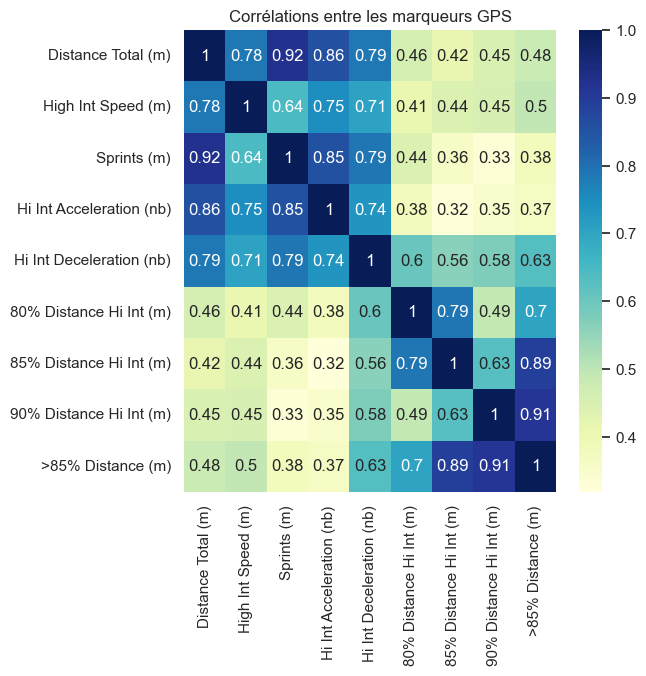

In [216]:
plt.figure(figsize=(6, 6))
sns.heatmap(Ma22_df[marqueurs].corr(), annot=True, cmap='YlGnBu')
plt.title('Corrélations entre les marqueurs GPS')
plt.show()

#### Faisons la même chose en séparant les joueurs en groupes <br> Same thing splitting players in two groups

In [217]:
cluster_bck = Ma22_df.loc[Ma22_df['Unit']=='Back', marqueurs].copy()
cluster_fwd = Ma22_df.loc[Ma22_df['Unit']=='Forward', marqueurs].copy()

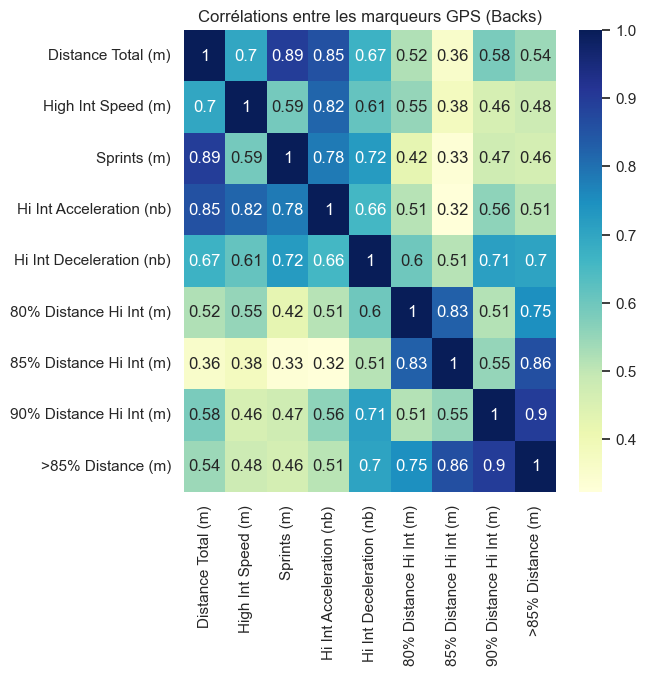

In [218]:
plt.figure(figsize=(6, 6))
sns.heatmap(cluster_bck.corr(), annot=True, cmap='YlGnBu')
plt.title('Corrélations entre les marqueurs GPS (Backs)')
plt.show()

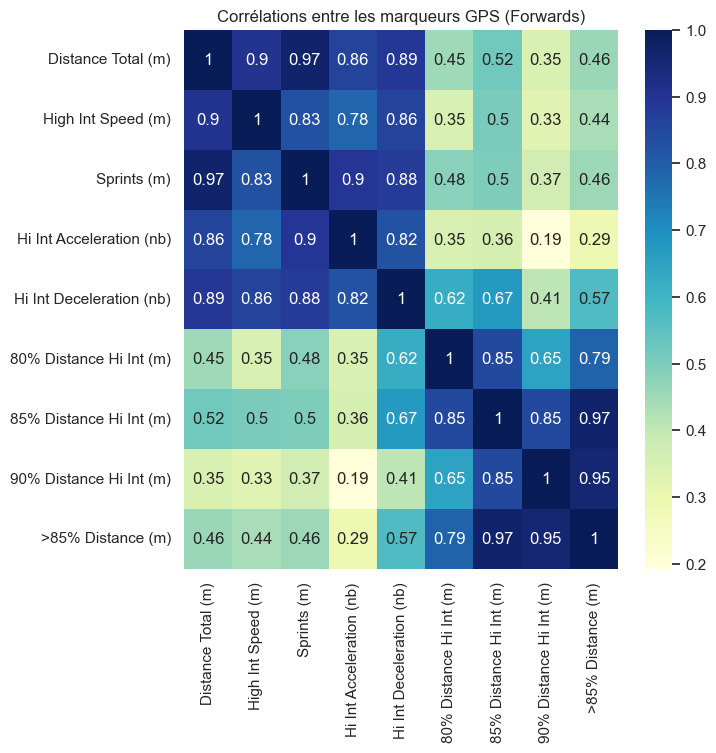

In [219]:
plt.figure(figsize=(7, 7))
sns.heatmap(cluster_fwd.corr(), annot=True, cmap='YlGnBu')
plt.title('Corrélations entre les marqueurs GPS (Forwards)')
plt.show()

#### Standardisons les données en gardons les deux groupes de joueurs distincts dans le processus <br> Scale (Z-score) the data keeping the two groups of players

In [220]:
z_scaler_back = StandardScaler()
z_scaler_forward = StandardScaler()

cluster_bck_z = z_scaler_back.fit_transform(cluster_bck)
cluster_fwd_z = z_scaler_forward.fit_transform(cluster_fwd)

#### Rassemblons les données des deux groupes <br> Combine the data from the two groups

In [221]:
Ma22_df_z = pd.concat([pd.DataFrame(cluster_bck_z, columns=marqueurs, index=cluster_bck.index), 
                       pd.DataFrame(cluster_fwd_z, columns=marqueurs, index=cluster_fwd.index)])

In [222]:
Ma22_df_z

,Distance Total (m),High Int Speed (m),Sprints (m),Hi Int Acceleration (nb),Hi Int Deceleration (nb),80% Distance Hi Int (m),85% Distance Hi Int (m),90% Distance Hi Int (m),>85% Distance (m)
Athlete,,,,,,,,,
Player 2,-0.651474,-0.801509,-0.228958,-0.910643,-0.465676,0.815276,2.247777,-0.398711,0.939066
Player 3,0.937909,0.635941,1.063979,0.787734,0.267191,0.251628,-0.422849,0.831049,0.283768
Player 33,-0.384494,-2.076489,-0.498319,-1.446973,-1.687121,-1.036708,-0.867953,-0.706152,-0.886408
Player 27,1.169671,0.680001,1.117851,1.055899,0.633625,1.539965,1.001485,0.984769,1.126294
Player 25,0.029041,-0.526136,-0.067340,-0.106149,0.022902,-0.795145,-0.867953,-0.706152,-0.886408
Player 19,0.600492,0.773628,0.686873,0.698346,1.000058,0.171107,0.734422,1.292209,1.173101
Player 32,-0.098200,-0.498598,-0.498319,0.072628,-0.099242,0.493191,-0.689912,-0.706152,-0.792794
Player 7,0.023361,-0.035971,-0.498319,0.519569,-1.442832,-1.036708,-0.867953,-0.706152,-0.886408
Player 8,0.282388,0.412888,0.794617,0.787734,0.022902,-1.036708,-0.867953,-0.706152,-0.886408


#### Faisons un test KMO (test mesure l'adéquation) <br> Run a KMO test

In [223]:
kmo_all, kmo_model = calculate_kmo(Ma22_df_z)
print('Overall KMO : {}'.format(kmo_model))
pd.DataFrame(index=marqueurs, data=kmo_all, columns=['KMO'])

Overall KMO : 0.691565785906865


,KMO
Distance Total (m),0.760253
High Int Speed (m),0.740776
Sprints (m),0.670684
Hi Int Acceleration (nb),0.852413
Hi Int Deceleration (nb),0.789471
80% Distance Hi Int (m),0.929756
85% Distance Hi Int (m),0.546326
90% Distance Hi Int (m),0.532265
>85% Distance (m),0.587363


#### Les scores ne sont pas si mauvais, lançons l'ACP <br> Scores are not so bad so let's run the PCA

In [224]:
pca = PCA()
Ma22_acp = pca.fit_transform(Ma22_df_z)

In [225]:
acp_df = pd.DataFrame(Ma22_acp, columns=['PC{}'.format(i+1) for i in range(len(pca.components_))])
full_df_acp = pd.concat([Ma22_df_z.reset_index(), acp_df], axis=1)

#### Calculons les corrélations de chaque marqueur avec les composantes principales <br> Find the correlations for each feature with each principal component

In [226]:
corr_table_Ma22 = pd.DataFrame(index=marqueurs, columns=acp_df.columns)

for m in corr_table_Ma22.index:
    for c in corr_table_Ma22.columns:
        corr, t = stats.pearsonr(full_df_acp[m], full_df_acp[c])
        
        corr_table_Ma22.loc[m, c] = corr

In [227]:
corr_table_Ma22 = corr_table_Ma22.astype('float')
corr_table_Ma22

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Distance Total (m),-0.866090,-0.406142,0.057656,-0.110111,-0.124792,0.137178,-0.123807,0.140600,0.001213
High Int Speed (m),-0.798672,-0.367086,-0.081657,0.452202,0.023163,0.082351,-0.076815,-0.054741,-0.000695
Sprints (m),-0.835248,-0.425844,0.052524,-0.288620,-0.010992,0.124612,0.009579,-0.138611,-0.001702
Hi Int Acceleration (nb),-0.802357,-0.485666,0.003888,0.042895,-0.171574,-0.220489,0.200035,0.020698,0.000673
Hi Int Deceleration (nb),-0.891767,-0.144752,-0.020544,-0.067363,0.406670,-0.108574,0.001010,0.040834,0.001121
80% Distance Hi Int (m),-0.763690,0.405152,-0.428992,-0.089655,-0.107198,-0.161817,-0.148934,-0.026444,-0.000185
85% Distance Hi Int (m),-0.767151,0.548858,-0.205839,0.020073,0.007330,0.193788,0.170967,0.020499,0.014281
90% Distance Hi Int (m),-0.737558,0.466285,0.467504,0.037740,-0.049872,-0.094572,-0.078007,-0.029263,0.015158
>85% Distance (m),-0.823680,0.540266,0.154584,0.031763,-0.016029,0.036102,0.047704,0.013055,-0.027447


<AxesSubplot:>

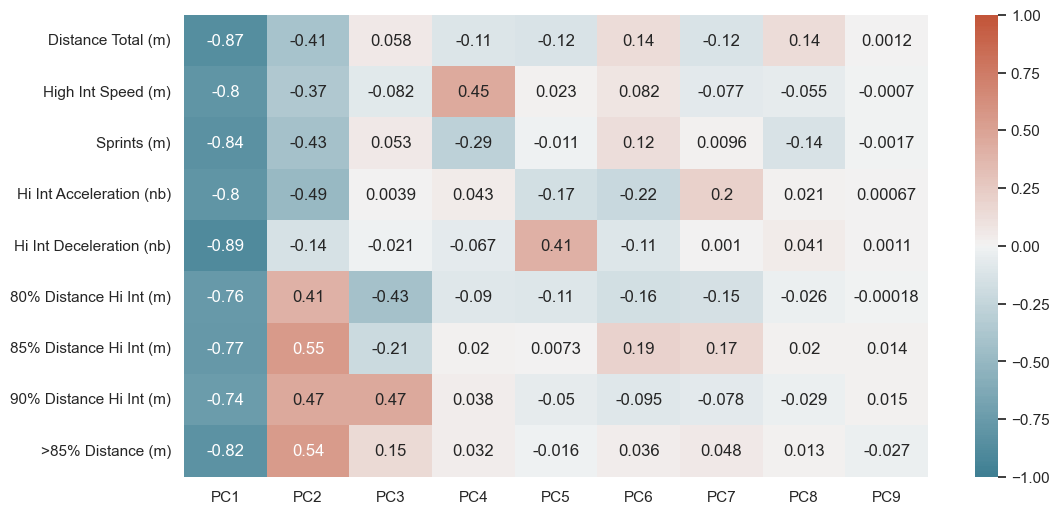

In [228]:
plt.figure(figsize=(12,6))
sns.heatmap(corr_table_Ma22, annot=True, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, n=200))

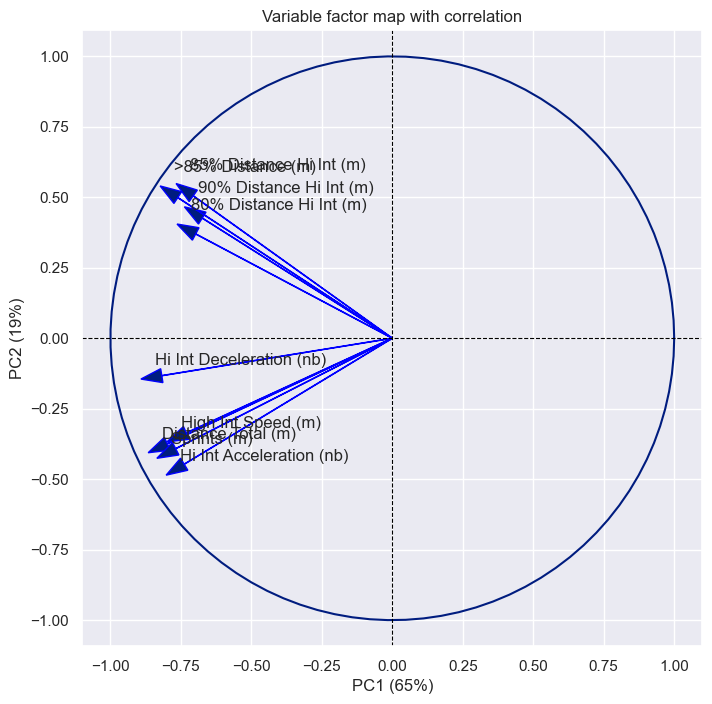

In [229]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(0, corr_table_Ma22.shape[0]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             corr_table_Ma22.iloc[i, 0],  #0 for PC1
             corr_table_Ma22.iloc[i, 1],  #1 for PC2
             head_width=0.05,
             length_includes_head=True, ec='blue')

    plt.text(corr_table_Ma22.iloc[i, 0] + 0.05,
             corr_table_Ma22.iloc[i, 1] + 0.05,
             marqueurs[i])

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.axis('equal')
plt.xlabel("PC1 (%s%%)" % str(pca.explained_variance_ratio_[0])[:4].lstrip("0."))
plt.ylabel("PC2 (%s%%)" % str(pca.explained_variance_ratio_[1])[:4].lstrip("0."))
ax.set_title('Variable factor map with correlation')
plt.show()

#### On peut constater qu'une grande partie de l'information est expliquée par le premier axe factoriel. L'analyse d'un seul entrainement, l'ACP n'est pas intéressante <br> We can see that a large part of the information is explained by the first factorial axis. PCA is not worth it for one training

#### Essayons en analysant les matchs <br> Let's try with games

#### Choissisons la médiane par défaut pour agréger chaque match <br> Let's use the median to aggregate each game

In [230]:
df_game_agg = df_game.groupby(['Week']).mean().round(0)
df_game_agg.drop(columns='m/min', inplace=True)

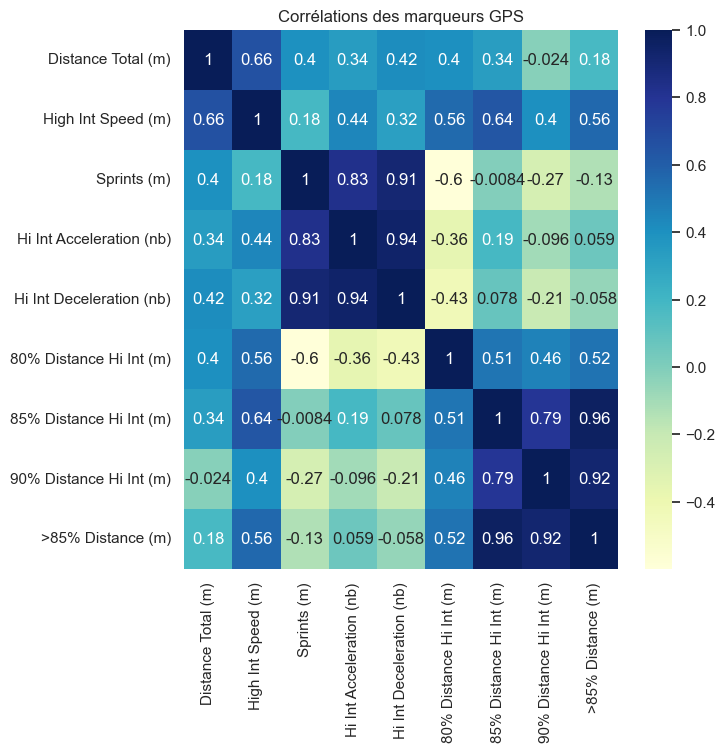

In [231]:
plt.figure(figsize=(7, 7))
sns.heatmap(df_game_agg.corr(), annot=True, cmap='YlGnBu')
plt.title('Corrélations des marqueurs GPS')
plt.show()

In [232]:
z_scaler_game = StandardScaler()

game_z = z_scaler_game.fit_transform(df_game_agg)

kmo_all, kmo_model = calculate_kmo(game_z)
print('Overall KMO : {}'.format(kmo_model))
pd.DataFrame(index=marqueurs, data=kmo_all, columns=['KMO'])

Overall KMO : 0.41359856635565473


C:\Users\raflg\anaconda3\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


,KMO
Distance Total (m),0.231880
High Int Speed (m),0.735690
Sprints (m),0.371038
Hi Int Acceleration (nb),0.533522
Hi Int Deceleration (nb),0.704938
80% Distance Hi Int (m),0.371415
85% Distance Hi Int (m),0.377969
90% Distance Hi Int (m),0.345477
>85% Distance (m),0.376909


In [233]:
df_game_z = pd.DataFrame(game_z, index=df_game_agg.index, columns=marqueurs)

#### Ici le KMO n'est vraiment pas intéressant, l'ACP ne vaut pas le coup non plus (allons tout de même au bout du processus) <br> Here KMO is very low so no need to run a PCA (let's go through the process anyway)

In [234]:
pca = PCA()
game_pca = pca.fit_transform(df_game_z)

In [235]:
game_acp_df = pd.DataFrame(game_pca, columns=['PC{}'.format(i+1) for i in range(len(pca.components_))])
full_game_acp = pd.concat([df_game_z.reset_index(), game_acp_df], axis=1)

In [236]:
full_game_acp

,Week,Distance Total (m),High Int Speed (m),Sprints (m),Hi Int Acceleration (nb),Hi Int Deceleration (nb),80% Distance Hi Int (m),85% Distance Hi Int (m),90% Distance Hi Int (m),>85% Distance (m),PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,Week 13,-0.101824,0.661068,0.203796,1.047570,0.563612,0.029005,1.490477,0.558160,1.175429,1.766293,-1.058432,-0.996188,-0.302433,0.620114,-0.295516,-0.107647,0.109951,0.006278
1,Week 14,1.501237,1.841234,-2.579186,-1.692228,-1.882705,3.832800,1.215063,0.970714,1.175429,4.299665,3.212576,2.856795,-0.404267,0.203015,0.140539,0.038285,-0.002438,-0.002730
2,Week 15,-1.233290,-1.029440,-0.364160,-0.126629,-0.251827,-0.675401,-1.263665,-1.092053,-1.257198,-2.574991,0.754363,-0.145356,-0.590806,0.214765,-0.000222,-0.010288,-0.046614,-0.027141
3,Week 16,0.541594,0.809918,1.055729,1.047570,0.971332,-0.182317,-0.437423,-0.679500,-0.562162,-0.484039,-2.029936,0.662509,-0.468656,-0.205753,-0.078883,0.051203,-0.203785,-0.029499
4,Week 18,0.095588,-0.604155,-0.193773,-1.496528,-0.863406,-0.252758,0.113406,0.558160,0.306634,0.117272,1.439691,-0.270730,1.176650,-0.501076,-0.182860,0.197883,0.105314,-0.006582
5,Week 19,1.020502,1.426581,1.282911,1.634669,1.379052,-0.041436,1.490477,0.145607,1.001670,1.932748,-2.903881,-0.197071,-0.060140,0.379869,-0.434470,-0.009947,0.021716,-0.001389
6,Week 20,0.071825,-0.093813,0.828547,1.047570,1.379052,-0.041436,0.388820,0.970714,0.654152,0.800133,-1.595072,-1.048258,0.048283,0.069278,0.941228,0.139612,-0.162708,0.020303
7,Week 21,-0.023225,0.990664,0.203796,0.851870,0.155893,0.029005,0.388820,0.970714,0.654152,1.315787,-0.732037,-0.564296,-0.601906,-0.495522,-0.006166,-0.317774,-0.016923,0.030845
8,Week 23,-0.390631,-0.104445,-0.364160,-0.518029,-0.659546,0.169886,-0.437423,0.558160,-0.040884,-0.021991,1.063926,-0.135036,-0.110129,-0.553524,0.180344,-0.085544,-0.153706,-0.015598
9,Week 25,-0.297409,-0.072549,-0.250569,-0.518029,-0.659546,0.310768,2.041306,2.208374,2.217984,3.028803,1.081673,-1.932463,0.908696,0.047763,-0.071899,-0.073118,-0.051391,-0.021978


#### Représenter graphiquement les CP1 et CP2 <br> Plot PC1 and PC2

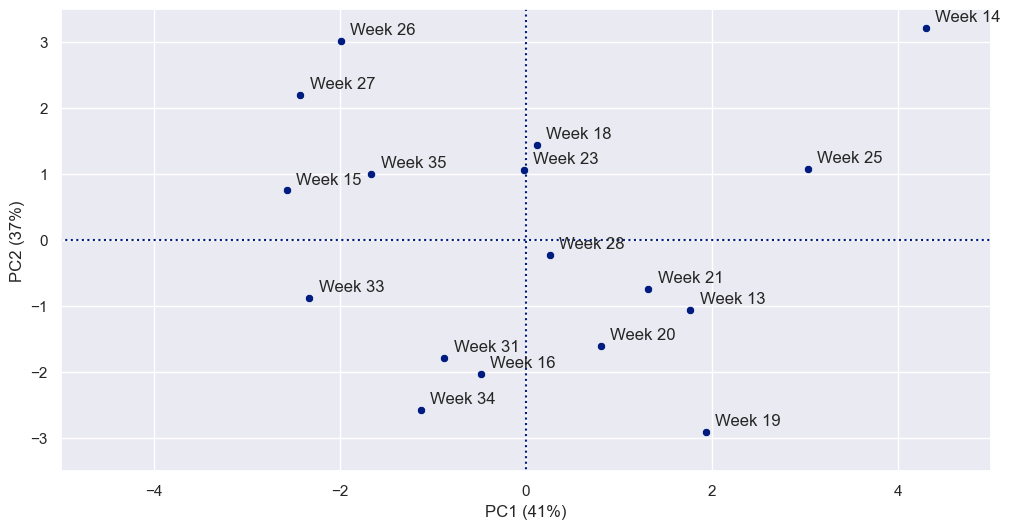

In [237]:
plt.figure(figsize=(12,6))
sns.set(palette= "dark")
sns.scatterplot(data=full_game_acp, x='PC1', y='PC2')
for i, w in enumerate(full_game_acp['Week']):
    plt.text(full_game_acp.loc[i, 'PC1']+0.1, full_game_acp.loc[i, 'PC2']+0.1, w)
#Variance expliquée par chaque CP
#Variance explained by each PC
plt.xlabel("PC1 (%s%%)" % str(pca.explained_variance_ratio_[0])[:4].lstrip("0."))
plt.ylabel("PC2 (%s%%)" % str(pca.explained_variance_ratio_[1])[:4].lstrip("0."))
plt.xlim(-5, 5)
plt.ylim(-3.5, 3.5)
plt.axvline(0, -3.5, 3.5).set_linestyle(':')
plt.axhline(0, -5, 5).set_linestyle(':')

In [238]:
corr_table_game = pd.DataFrame(index=marqueurs, columns=['PC{}'.format(i+1) for i in range(len(pca.components_))])

In [239]:
for m in corr_table_game.index:
    for c in corr_table_game.columns:
        corr, t = stats.pearsonr(full_game_acp[m], full_game_acp[c])
        
        corr_table_game.loc[m, c] = corr

corr_table_game = corr_table_game.astype('float')

<AxesSubplot:>

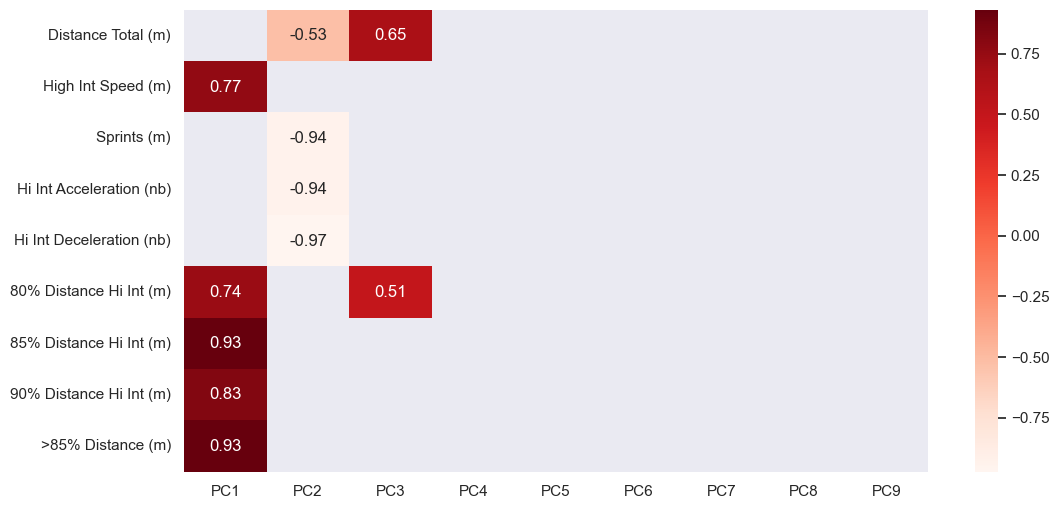

In [240]:
filteredDf = corr_table_game[(corr_table_game >= .5) | (corr_table_game <= -.5)]
plt.figure(figsize=(12,6))
sns.heatmap(filteredDf, annot=True, cmap='Reds')

#### Ici nous pourrions dire que CP1 est représentée par des marqueurs de très hautes intensités et CP2 par des marqueurs de hautes intensités <br> Here it seems PC1 is represented by very high intensities features and PC2 by high intensities features

#### Nous pouvons voir sur le graph des CP que les matchs se situant à droite (corrélation positive de CP1) et en bas (corrélation négative de CP2) du quadrant, sont caractérisés par des hautes et très hautes intensités (c'est l'inverse pour les matchs situés à gauche et haut du quadrant) <br> We can see on the PC plot that games à the right (positive correlation of PC1) and the bottom (negtive correlation of PC2) of the quadrant are characterized by high and very high intensities (the opposite for games on the left and at the top of the quadrant)

#### Mais rappelons nous que le test de KMO nous indiquait une ACP peu intéressante. En effet la frontière entre hautes et très hautes intensités est difficile à déterminer <br> But remember that the KMO test told us about a non-interesting PCA. Indeed the line between high and very high intensities is difficult to determine

#### Alors que faire ? Essayer de réunir des marqueurs ensembles afin de réduire les dimension de la base de données. En réalisant plusieurs étapes de quadrant et d'attribution d'un score en fonction de la position du point sur le graph... <br> So what can we do ? Try to get some features together to reduce the shape of the database. By doing several steps of plotting a quadrant and assigning a score depending of the position of the point on the graph...

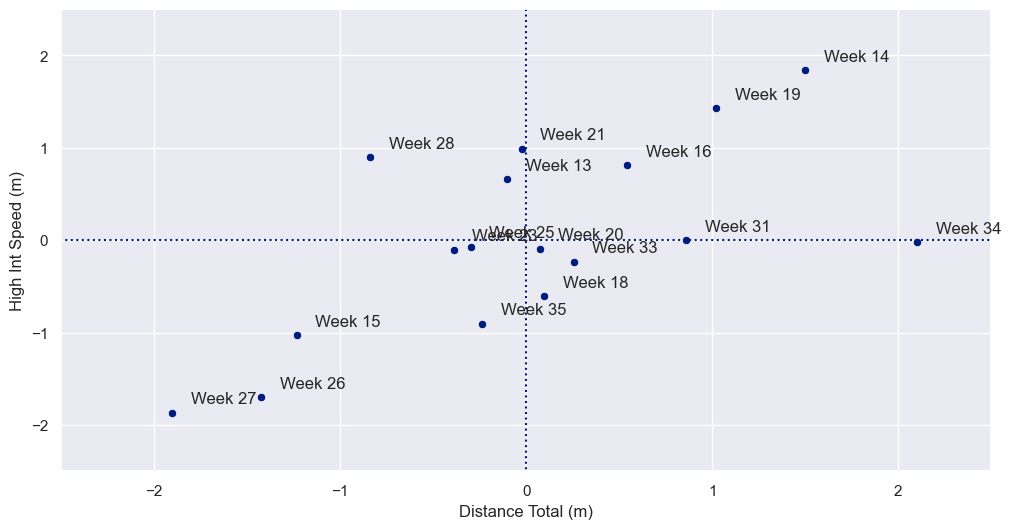

In [241]:
plt.figure(figsize=(12,6))
sns.set(palette= "dark")
sns.scatterplot(data=full_game_acp, x='Distance Total (m)', y='High Int Speed (m)')
for i, w in enumerate(full_game_acp['Week']):
    plt.text(full_game_acp.loc[i, 'Distance Total (m)']+0.1, full_game_acp.loc[i, 'High Int Speed (m)']+0.1, w)
plt.xlabel('Distance Total (m)')
plt.ylabel('High Int Speed (m)')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.axvline(0, -3.5, 3.5).set_linestyle(':')
plt.axhline(0, -5, 5).set_linestyle(':')

#### Donc ici nous voyons que les matchs en haut à droite sont ceux avec de plus grandes valeurs pour 'Distance Total (m)' et 'High Int Speed (m)'. Donc des matchs à plus gros coût énergétique. Ce qui permettrait d'établir un score de ""charge"" énergétique <br> So here we see that games on the top and the right have higher values for 'Distance Total (m)' and 'High Int Speed (m)' features. So the energy cost is higher for those games. This would make it possible to establish a score of energy ""load""

In [242]:
df_game_agg['Ac/Dc (nb)'] = df_game_agg['Hi Int Acceleration (nb)'] + df_game_agg['Hi Int Deceleration (nb)']

z_scaler = StandardScaler()
df_quad_z = z_scaler.fit_transform(df_game_agg)

quad_df_2 = pd.DataFrame(df_quad_z, columns=['Distance Total (m)', 'High Int Speed (m)', 'Sprints (m)', 
                                             'Hi Int Acceleration (nb)', 'Hi Int Deceleration (nb)', 
                                             '80% Distance Hi Int (m)', '85% Distance Hi Int (m)',
                                             '90% Distance Hi Int (m)', '>85% Distance (m)', 'Ac/Dc (nb)'], 
                         index=df_game_agg.index)
quad_df_2.reset_index(inplace=True)

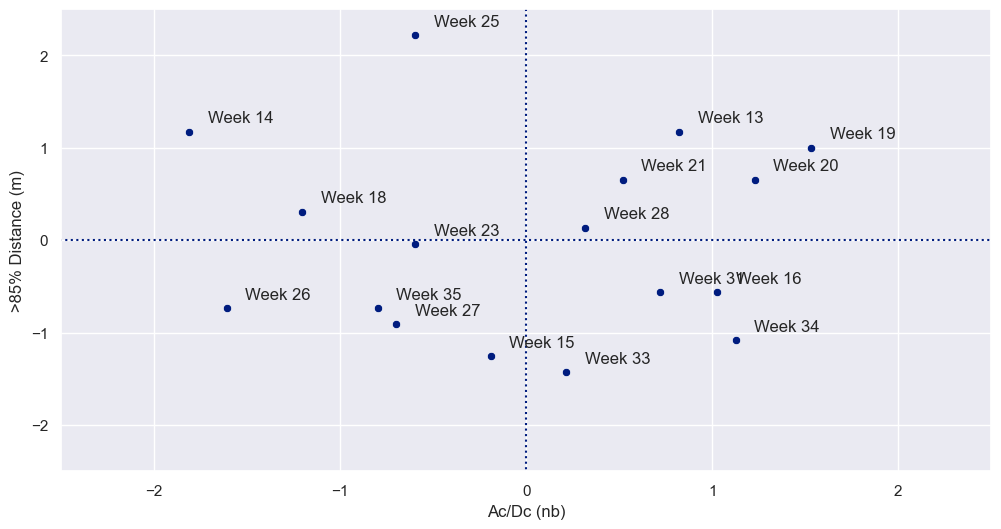

In [243]:
plt.figure(figsize=(12,6))
sns.set(palette= "dark")
sns.scatterplot(data=quad_df_2, x='Ac/Dc (nb)', y='>85% Distance (m)')
for i, w in enumerate(quad_df_2['Week']):
    plt.text(quad_df_2.loc[i, 'Ac/Dc (nb)']+0.1, quad_df_2.loc[i, '>85% Distance (m)']+0.1, w)
plt.xlabel('Ac/Dc (nb)')
plt.ylabel('>85% Distance (m)')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.axvline(0, -3.5, 3.5).set_linestyle(':')
plt.axhline(0, -5, 5).set_linestyle(':')

#### Et ici nous voyons que les matchs en haut à droite sont ceux avec de plus grandes valeurs pour 'Ac/Dc (nb)' et '>85% Distance (m)'. Donc des matchs à plus gros coût musculaire/neural. Ce qui permettrait d'établir un score de ""charge"" musculaire/neural <br> And here we see that games on the top and the right have higher values for 'Ac/Dc (nb)' and '>85% Distance (m)' features. So the muscular/neural cost is higher for those games. This would make it possible to establish a score of muscular/neural ""load""

#### L'analyse la plus importante restera une analyse longitudinale durant la saison <br> The most important analysis will remain a longitudinal analysis during the season